Script to make a Venn diagram of number of genes in each condition.

Input files are downsampled

data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/
please download:<br>
10005CN48_C1_downsamp.tsv<br>
10005CN48_D1_downsamp.tsv <br>
10005CN48_E1_downsamp.tsv <br>
10015CN60_E2_downsamp.tsv <br>
10015CN84_C2_downsamp.tsv <br>
10015CN84_D2_downsamp.tsv <br>
10005CN48_C1_stdata_under_tissue_IDs.txt <br>
10005CN48_D1_stdata_under_tissue_IDs.txt <br>
10005CN48_E1_stdata_under_tissue_IDs.txt <br>
10015CN60_E2_stdata_under_tissue_IDs.txt <br>
10015CN84_C2_stdata_under_tissue_IDs.txt <br>
10015CN84_D2_stdata_under_tissue_IDs.txt <br>

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from matplotlib_venn import venn2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Make a sample-condition dictionary
sam_cond = {'ST': ['10005CN48_C1', '10005CN48_D1', '10005CN48_E1'],
           'sm-omics':['10015CN84_D2', '10015CN84_C2', '10015CN60_E2']}

In [4]:
# Load input files, tsv files from st-pipeline

path = '../../smomics_data'

samples_list = ['10005CN48_C1', '10005CN48_D1', '10005CN48_E1', '10015CN84_D2', '10015CN84_C2', '10015CN60_E2']
    
files_dict = {}
    
for filename in samples_list:
    
    file = pd.read_csv(os.path.join(path, filename + '_downsamp_stdata.tsv'), sep = '\t', index_col=0)

    files_dict[filename] = file.T


In [5]:
'Splits counts file to inside vs outside tissue'
genes_under_tissue_dict = {}
    
for filename in samples_list:
    
    file = pd.read_csv(os.path.join(path, filename + '_stdata_under_tissue_IDs.txt'), sep = '\t', index_col=0)
    
    spot_coord = list()
    
    # 10005CN48_E1 samples have spot coordinates in float...
    if filename.startswith('10005CN48_E1'):
        for spots in list(file):
            spot_tmp = [ float(elem) for elem in spots.split('_') ]
            spot_tmp2 = [ round(elem, 0) for elem in spot_tmp ]
            spot_tmp3 = [ int(elem) for elem in spot_tmp2 ]

            new_spot_coord = str(spot_tmp3[0]) + 'x' + str(spot_tmp3[1])
            spot_coord.append(new_spot_coord)
    else:
        for spots in list(file):
            spots_tmp = spots.split('_')
            new_spot_coord = str(spots_tmp[0]) + 'x' + str(spots_tmp[1])   
            spot_coord.append(new_spot_coord)

    genes_under_tissue_dict[filename] = spot_coord

files_underoutside_tissue_dict = {}

for k, v in files_dict.items():
    #print(genes_under_tissue_dict[k])
    v_under_tissue = v[genes_under_tissue_dict[k]]

    # Spots outside of tissue
    spots_outside_tissue = [x for x in list(v) if x not in list(v_under_tissue)]
    v_outside_tissue = v[spots_outside_tissue] 

    files_underoutside_tissue_dict[k] = [v_under_tissue, v_outside_tissue]

In [6]:
# Filter on sequencing depth
seq_depth = {'10015CN84_D2':[23113376, 23],
            '10015CN60_E2':[33876251, 33],
            '10015CN84_C2':[28174220, 28],
            '10005CN48_C1':[71022006, 71],
            '10005CN48_D1':[75643539, 75],
            '10005CN48_E1': [58631758, 58]}

gene_dict = {}
for key, value in files_underoutside_tissue_dict.items():
    
    for i, val in enumerate(value): # [inside/outside] of tissue  
        
        # Sum the counts for each gene
        val['tot count'] = val.sum(axis=1)

        # Remove genes (rows) where the total sum is less than xx       
        value_red = val[val['tot count'] > seq_depth[key][1]]

        # Remove tot count column
        value_red.drop(['tot count'], axis = 1, inplace=True)
               
        if i == 0: # inside tissue
            # Store these gene name
            genes = value_red.index.tolist()    
            gene_dict[key] = genes
            print(key)
            print(len(genes))

10005CN48_C1
3887
10005CN48_D1
3524
10005CN48_E1
2759
10015CN84_D2
9338
10015CN84_C2
8699
10015CN60_E2
9769


In [7]:
# Take the average of the 3 replicates
ave_genes_dict = {}

for key, value in sam_cond.items():
    
    genes_in_common = list()
    
    for gene_key, gene_value in gene_dict.items():
        
        print(len(gene_value))
        
        if gene_key in value:
            
            genes_in_common.append(gene_value)

    # Which genes are present in all three samples? 
    ave_genes = list(set(genes_in_common[0]).intersection(genes_in_common[1],genes_in_common[2]))
    
    ave_genes_dict[key] = ave_genes


3887
3524
2759
9338
8699
9769
3887
3524
2759
9338
8699
9769


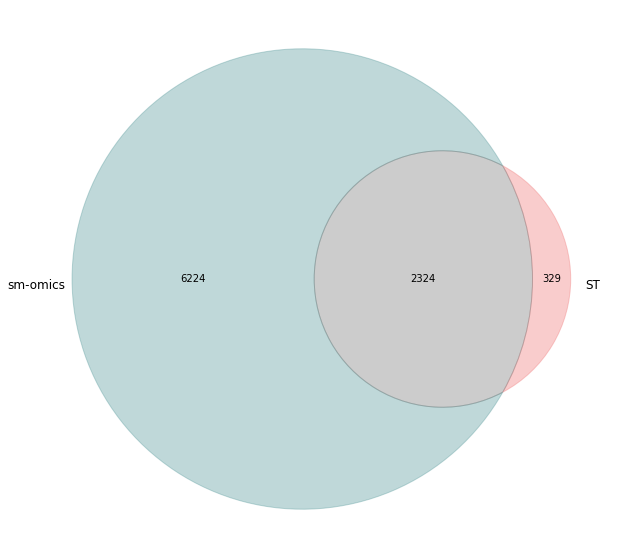

In [8]:
# Plot figure with subplots of different sizes
fig = plt.figure(figsize=(10, 5)) 
ax1 = plt.subplot2grid((1, 1), (0, 0))

a = venn2([set(ave_genes_dict['sm-omics']), set(ave_genes_dict['ST'])], set_labels = ('sm-omics', 'ST'), ax=ax1)

#ax1.text(-0.8, 0.5,'A', fontsize=22)

lbl = a.get_label_by_id('A')
x, y = lbl.get_position()
lbl.set_position((-0.65, 0))  
lbl = a.get_label_by_id('B')
x, y = lbl.get_position()
lbl.set_position((0.6, 0))

a.get_patch_by_id('10').set_color('cadetblue')
a.get_patch_by_id('01').set_color('lightcoral')
a.get_patch_by_id('11').set_color('grey')

fig.set_size_inches(20, 10)
plt.savefig("../../figures/SM_ST_Venn.pdf", transparent=True, bbox_inches = 'tight',
   pad_inches = 0, dpi=1200)

In [9]:
((6224+2324)/(2324+329))

3.222012815680362

In [10]:
6224+2324

8548

In [12]:
2324+329

2653

In [13]:
"Translate ensembl gene symbols to refseq"
genes_names_dict = pd.read_csv("../../smomics_data/Gene_names_mm.txt", header = None)
genes_names_dict['ensemble'] = list([i.split("_")[0] for i in genes_names_dict[0]])
genes_names_dict['names'] = list([i.split("_")[1] for i in genes_names_dict[0]])
genes_names_dict = genes_names_dict.drop(0, axis = 1)
genes_names_dict.index = genes_names_dict['ensemble']
genes_names_dict = genes_names_dict.drop('ensemble', axis = 1)
genes_names_dict_final = genes_names_dict.to_dict()

In [14]:
"Get sm-omics gene names"
smomics_genes =  [genes_names_dict_final['names'][key] for key in ave_genes_dict['sm-omics']]

In [15]:
"Get st gene names"
st_genes =  [genes_names_dict_final['names'][key] for key in ave_genes_dict['ST']]

In [16]:
"Check if genes in sm-omics and st"
for gene in ['Camk4', 'Ctgf','Lancl3', 'Cbln4']:
    if gene in smomics_genes:
        print(gene, " gene in SM-Omics")
    if not gene in st_genes:
        print(gene, " gene not in ST")

Camk4  gene in SM-Omics
Camk4  gene not in ST
Ctgf  gene in SM-Omics
Ctgf  gene not in ST
Lancl3  gene in SM-Omics
Lancl3  gene not in ST
Cbln4  gene in SM-Omics
Cbln4  gene not in ST
